# MITGCM Intermediate Parameters Processing

**Purpose**: Code for computing intermediate derived variables from the raw model diagnostics near the ocean surface. These include: 

1. Surface Horizontal Velocity Gradients: Vorticity, Divergence, and Strain
2. Potential Density Surface Field. 

All the depth parameter processing will be done when reading the model data from the mitgcm binary files. 

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook

In [1]:
%matplotlib inline

Import python libraries

In [2]:
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
from netCDF4 import Dataset, num2date
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import cmocean
from scipy.interpolate import interp1d

# Set path to access python functions
ROOT = '/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/'
sys.path.append(ROOT + 'AirSeaCoupling/tools/')

#--- Other Functions ---# 
import cartopy_figs as cart

Set data analysis parameters

In [3]:
# Set processing parameters
option_plot          = 0           # Specifies if supplementary plots are plotted
option_proc          = 'gradients' # Speicifies which processing will occur. Options include: 'gradients' or 'density'

# Set time and space parameters  
lat_bnds     = [33, 35]                      # Specifies the latitude bounds for the region to analyze
lon_bnds     = [-123 % 360, -120 % 360]      # Specifies the longitude bounds for the region to analyze

# Set path to project directory
PATH = ROOT + 'AirSeaCoupling/data/mitgcm/SWOT_MARA_RUN4_LY/'
PATH_figs =  ROOT + 'AirSeaCoupling/figs_server/mitgcm/scale_analysis/'
PATH_bathy  = ROOT + 'AirSeaCoupling/data/bathymetry/'

# Set plotting parameters 
fontsize = 16

Load mitgcm data netcdf files 

In [4]:
if option_proc == 'gradients':

    # Obtain filename paths
    filename_u = PATH + "UVEL_CCS4_hrly_ts_ext.nc"
    filename_v = PATH + "VVEL_CCS4_hrly_ts_ext.nc"

    # Generate the nc data structure
    nc_u = Dataset(filename_u, 'r')
    nc_v = Dataset(filename_v, 'r')

    # Extract data variables
    z      = nc_u.variables['Z'][:]

    lon_XG = nc_u.variables['XG'][:]
    lat_YC = nc_u.variables['YC'][:]
    lon_XC = nc_v.variables['XC'][:]
    lat_YG = nc_v.variables['YG'][:]
    time   =  num2date(nc_u.variables['time'][:], nc_u.variables['time'].units)

    u_raw  = nc_u.variables['UVEL'][:]
    v_raw  = nc_v.variables['VVEL'][:]

elif option_proc == 'density':

    # Obtain filename paths
    filename_temp = PATH + "THETA_CCS4_hrly_ts_ext.nc"
    filename_salt = PATH + "SALT_CCS4_hrly_ts_ext.nc"

    # Generate the nc data structure
    nc_temp = Dataset(filename_temp, 'r')
    nc_salt = Dataset(filename_salt, 'r')

    # Extract data variables

    lon = nc_temp.variables['XC'][:]
    lat = nc_temp.variables['YC'][:]
    time =  num2date(nc_temp.variables['time'][:], nc_temp.variables['time'].units)

    THETA = nc_temp.variables['THETA'][:]
    S = nc_salt.variables['SALT'][:]

# Convert cftime.DatetimeGregorian to Python datetime objects
time_dt = np.array([datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time])

### Processing horizontal velocity gradients

In [11]:
if option_proc == 'gradients':

    # Convert to a ndarray
    u_raw = np.asarray(u_raw)
    v_raw = np.asarray(v_raw)
    lon_XG = np.asarray(lon_XG)
    lat_YC = np.asarray(lat_YC)
    lon_XC = np.asarray(lon_XC)
    lat_YG = np.asarray(lat_YG)

    # Slice lon_XG and lat_YG to match lon_XC and lat_YC bounds respectively 
    lon_min, lon_max = np.min(lon_XC), np.max(lon_XC)
    lat_min, lat_max = np.min(lat_YC), np.max(lat_YC)
    idx_lon = (lon_XG >= lon_min) & (lon_XG <= lon_max)
    idx_lat = (lat_YG >= lat_min) & (lat_YG <= lat_max)
    lon_XG_c = lon_XG[idx_lon]
    lat_YG_c = lat_YG[idx_lat]

    # Apply the same slicing operation to u_raw and v_raw (recall: dim(u_raw) =  (time,lat_YC,lon_XG) and dim(v_raw) =  (time,lat_YG,lon_XC))
    u_raw_c = u_raw[:,:,idx_lon]
    v_raw_c = v_raw[:,idx_lat,:]

    # Set processing parameters
    ntime,_,_ = np.shape(u_raw_c)
    nlat,nlon = np.size(lat_YC),np.size(lon_XC)
    lon       = lon_XC
    lat       = lat_YC 

    # Initalize arrays
    vort   = np.zeros((ntime,nlat,nlon)) 
    div    = np.zeros((ntime,nlat,nlon)) 
    strain = np.zeros((ntime,nlat,nlon)) 
    speed  = np.zeros((ntime,nlat,nlon)) 
    dir    = np.zeros((ntime,nlat,nlon)) 
    u_int  = np.zeros((ntime,nlat,nlon)) 
    v_int  = np.zeros((ntime,nlat,nlon)) 

    # Loop through time
    for itime in range(0,ntime): 

        # Set progress bar
        progress = (itime + 1) / (len(time))
        sys.stdout.write(f"\rProgress: {progress:.1%}")
        sys.stdout.flush()

        # Grab the ith time frame 
        u_i = np.squeeze(u_raw_c[itime,:,:])
        v_i = np.squeeze(v_raw_c[itime,:,:])

        # Interpolate u_z from YC,XG grid onto the YC,XC grid 
        # Interpolate each row along columns (axis=1)
        u_int[itime,:,:] = np.array([
                            interp1d(lon_XG_c, row, kind='linear', bounds_error=False)(lon)
                            for row in u_i
        ])

        # Interpolate v_z from YG,XC grid onto the YC,XC grid 
        v_int[itime,:,:] = np.array([
                            interp1d(lat_YG_c, col, kind='linear', bounds_error=False)(lat)
                            for col in v_i.T
        ]).T 

        # Compute the horizontal speed 
        speed[itime,:,:] = np.sqrt(u_int[itime,:,:]**2 + v_int[itime,:,:]**2)

        # Compute the direction (directional convention: Going towards, CW, reference north)
        dir[itime,:,:] = (90 - np.degrees(np.arctan2(v_int[itime,:,:], u_int[itime,:,:]))) % 360

        # Compute spatial derivatives at the scale of the grid
        dx = abs(lon[1] - lon[0]) * 111*10**3 # Units: meters (ignoring the spherical dependency)
        dy = abs(lat[1] - lat[0]) * 111*10**3 # Units: meters 
        dudx = np.gradient(u_int[itime,:,:], dx, axis=1) # Units: m/s/m = 1/s
        dvdy = np.gradient(v_int[itime,:,:], dy, axis=0)
        dvdx = np.gradient(v_int[itime,:,:], dx, axis=1)
        dudy = np.gradient(u_int[itime,:,:], dy, axis=0)

        # Compute the coriolis parameter (the local vertical planetary vorticity)
        omega = 7.2921 * 10**(-5)            # Magnitude of Earth's rotation rate, Units: rad/s 
        f = 2*omega*np.sin(np.deg2rad(lat))  # Units: rad/s

        # Compute vorticity, divergence, and strain normalized by the planetary vorticity
        vort[itime,:,:]   = (dvdx - dudy)/f[:, np.newaxis]
        div[itime,:,:]    = (dudx + dvdy)/f[:, np.newaxis]
        strain[itime,:,:] = (((dudx - dvdy)**2 + (dvdx + dudy)**2)**(1/2))/f[:, np.newaxis]  # Total strain magnitude linear combination of stretching and angular spreading strain
        



Progress: 100.0%

### Processing Density 

In [ ]:
if option_proc == 'density': 

    # Generate a 

    # Initialize an array for the pressure, conservative temperature, absolute salinity, and in-situ/potential density 
    pressure = np.zeros_like(THETA)
    CT       = np.zeros_like(THETA)
    SA       = np.zeros_like(THETA)
    density  = np.zeros_like(THETA)
    sigma0   = np.zeros_like(THETA)

    # Loop through profile time steps 
    for idata in range(0,nprofile):

        # Compute pressure from depth and latitude
        pressure[:,idata] = gsw.conversions.p_from_z(z,lat)  # Units: dbar

        # Compute absolute salinity 
        SA[:,idata] = gsw.conversions.SA_from_SP(salinity[:,idata], pressure[:,idata], lon[idata], lat[idata]) # Units: g/kg

        # Compute Conservative temperature from absolute salinity, in-situ temperature and pressure
        CT[:,idata] = gsw.conversions.CT_from_t(SA[:,idata], temperature[:,idata], pressure[:,idata])  # Units: degrees Celcius

        # Compute in-situ and potential density (with reference pressure of 0 dbar) 
        density[:,idata] = gsw.density.rho(SA[:,idata],CT[:,idata],pressure[:,idata])  # Units: kg/m^3
        sigma0[:,idata] = gsw.density.sigma0(SA[:,idata], CT[:,idata])  # Units: kg/m^3

Save intermediate data in a netCDF for future use

In [13]:
# Save variables in data arrays

if option_proc == 'density': 

    #--- Sea State Varibles ---# 
    Pressure = xr.DataArray(data=pressure, 
                        dims=['depth','profile',],
                        coords=dict(depth=depth,profile=profile),
                        attrs=dict(
                            description='Pressure profiles.',
                            units='dbar'
                            )
    )

    Density = xr.DataArray(data=density, 
                        dims=['depth','profile',],
                        coords=dict(depth=depth,profile=profile),
                        attrs=dict(
                            description='In-situ Density profiles.',
                            units='kg/m^3'
                            )
    ) 

    SIG = xr.DataArray(data=sigma0, 
                        dims=['depth','profile',],
                        coords=dict(depth=depth,profile=profile),
                        attrs=dict(
                            description='Potential Density anomaly profiles referenced to the pressure at the sea surface.',
                            units='kg/m^3'
                            )
    ) 

    CTemp = xr.DataArray(data=CT, 
                        dims=['depth','profile',],
                        coords=dict(depth=depth,profile=profile),
                        attrs=dict(
                            description='Conservative temperature profiles.',
                            units='degrees Celcius'
                            )
    ) 

    ASal = xr.DataArray(data=SA, 
                        dims=['depth','profile',],
                        coords=dict(depth=depth,profile=profile),
                        attrs=dict(
                            description='Absolute Salinity profiles.',
                            units='g/kg'
                            )
    )

if option_proc == 'gradients': 

    #--- Interpolated Velocity Components ---#
    u = xr.DataArray(data=u_int,
                        dims=['time_dt', 'lat', 'lon'],
                        coords=dict(time_dt=time_dt, lat=lat, lon=lon),
                        attrs=dict(
                            description='The x-component (zonal) of velocity at ' + str(z) + ' meter depth. This velocity components has been interpolated from (time,lat_YC,lon_XG) to (time,lat_YC,lon_XC).',
                            units='m/s'
                        )
    )

    v = xr.DataArray(data=div,
                        dims=['time_dt', 'lat', 'lon'],
                        coords=dict(time_dt=time_dt, lat=lat, lon=lon),
                        attrs=dict(
                            description='The y-component (meridional) of velocity at ' + str(z) + ' meter depth. This velocity components has been interpolated from (time,lat_YG,lon_XC) to (time,lat_YC,lon_XC).',
                            units='m/s'
                    )
    )

    #--- Horizontal Velocity Gradients ---# 
    CURL = xr.DataArray(data=vort,
                        dims=['time_dt', 'lat', 'lon'],
                        coords=dict(time_dt=time_dt, lat=lat, lon=lon),
                        attrs=dict(
                            description='The z-component of vorticity computed from the horizontal velocity components (u,v) at ' + str(z) + ' meter depth. The vorticity is normalized by the planetary vorticity f. By normalizing by f, the quantity becomes unitless.',
                            units=''
                        )
    )

    DIV = xr.DataArray(data=div,
                        dims=['time_dt', 'lat', 'lon'],
                        coords=dict(time_dt=time_dt, lat=lat, lon=lon),
                        attrs=dict(
                            description='The divergence of the horizontal velocity components (u,v) at ' + str(z) + ' meter depth. The divergence is normalized by the planetary vorticity f. By normalizing by f, the quantity becomes unitless.',
                            units=''
                    )
    )

    STRAIN = xr.DataArray(data=strain,
                        dims=['time_dt', 'lat', 'lon'],
                        coords=dict(time_dt=time_dt, lat=lat, lon=lon),
                        attrs=dict(
                            description='Total strain magnitude at ' + str(z) + ' meter depth (the second invariant of the 2D strain rate tensor) which tells you how strongly the flow is deforming (combines information from the stretching and angular spreading strain rates). The total strain magnitude is normalized by the planetary vorticity f. By normalizing by f, the quantity becomes unitless.',
                            units='m'
                    )
    )

    SPEED = xr.DataArray(data=speed,
                        dims=['time_dt', 'lat', 'lon'],
                        coords=dict(time_dt=time_dt, lat=lat, lon=lon),
                        attrs=dict(
                            description='The magitude of the horizontal velocity components (u,v) at ' + str(z) + ' meter depth.',
                            units='m/s'
                    )
    )

    DIR = xr.DataArray(data=dir,
                        dims=['time_dt', 'lat', 'lon'],
                        coords=dict(time_dt=time_dt, lat=lat, lon=lon),
                        attrs=dict(
                            description='The direction of the horizontal velocity components (u,v) at ' + str(z) + ' meter depth. Directional convention: going towards, clockwise, and reference north.',
                            units='degrees'
                    )
    )
    


# Create a data set from data arrays 
if option_proc == 'gradients':  

    data_grad = xr.Dataset({'CURL':CURL,'DIV':DIV,'STRAIN':STRAIN, 'SPEED':SPEED, 'DIR':DIR})
    file_path_grad = PATH + "/mitgcm_intermediate_data_gradients_depth_" + str(abs(z)) + ".nc"

    data_vel = xr.Dataset({'u':u,'v':v})
    file_path_vel = PATH + "/mitgcm_intermediate_data_velocity_depth_" + str(abs(z)) + ".nc"

if option_proc == 'density':  

    data = xr.Dataset({'Pressure':Pressure,'Density':Density,'SIG':SIG,'CTemp':CTemp,'ASal':ASal})
    file_path = PATH + "/mitgcm_intermediate_data_density_depth" + str(abs(z)) + ".nc"

# Check if file exists, then delete it
if option_proc == 'gradients':
    if os.path.exists(file_path_grad):
        os.remove(file_path_grad)
    if os.path.exists(file_path_vel):
        os.remove(file_path_vel)
else: 
    if os.path.exists(file_path):
        os.remove(file_path)

# Create netcdf file
if option_proc == 'gradients':
    data_grad.to_netcdf(file_path_grad,mode='w')
    data_vel.to_netcdf(file_path_vel,mode='w')
else: 
    data.to_netcdf(file_path,mode='w')

### Developmental Code

In [ ]:
#--- Water Depth ---# 
WATER_DEPTH = xr.DataArray(data=water_depth,
                           dims=['profile'],
                           coords=dict(profile=profile),
                           attrs=dict(
                               description='Depth of water which the spray glider performed its profile. Water depth of profile is obtained by finding the closest grid point in the ETOPO2 bathymetry map to the position of the spray glider.',
                               units='m'
                           )
)
WATER_DEPTH_uv = xr.DataArray(data=water_depth_uv,
                              dims=['profile'],
                              coords=dict(profile=profile),
                              attrs=dict(
                                  description='Depth of water which the spray glider performed its profile for horizontal velocity measurements. Water depth of profile is obtained by finding the closest grid point in the ETOPO2 bathymetry map to the position of the spray glider.',
                                  units='m'
                           )
)

print(np.shape(lon_XC))
print(np.shape(lon_XG))
print('------------')

print(np.shape(lat_YC))
print(np.shape(lat_YG))
print('------------')

print(np.shape(u_raw))
print(np.shape(v_raw))
print('------------')



(144,)
(240,)
------------
(96,)
(120,)
------------
(17661, 96, 240)
(17661, 120, 144)
------------


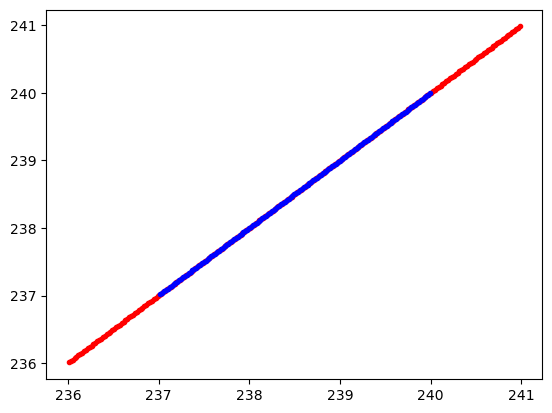

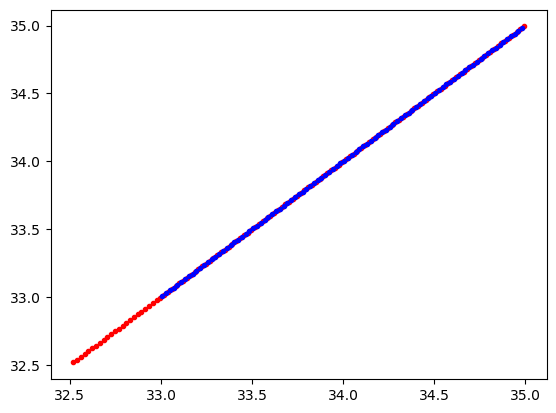

In [51]:
plt.plot(lon_XG,lon_XG,'.r')
plt.plot(lon_XC,lon_XC,'.b')

plt.show()

plt.plot(lat_YG,lat_YG,'.r')
plt.plot(lat_YC,lat_YC,'.b')

plt.show()

In [42]:
print(np.max((1/f)*(1/60)*(1/60)))
print(np.min((1/f)*(1/60)*(1/60)))

3.4964085
3.322045
